# Power & Language - Topic Model experiments

- [Data @OSF](https://osf.io/dwnxt/?view_only=e75faa4f54244361aa198e257b4fecf9)

## Setup

In [1]:
%%bash
pip install pandas numpy \
            scikit-learn
pip install huggingface
pip install setfit
pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=a76498368bbfdbfbcdda53ceaa8ccd41b121b162b6a1169cdcdea9f05114f8f2
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download data

In [2]:
%%bash
curl -s -L -o osf-files.zip 'https://files.de-1.osf.io/v1/resources/dwnxt/providers/osfstorage/?view_only=e75faa4f54244361aa198e257b4fecf9&zip='
unzip osf-files.zip

Archive:  osf-files.zip
  inflating: Online Supplement.pdf   
  inflating: Mini Meta/Mini Meta-analysis.xlsx  
  inflating: Pilot Study/Data Pilot Study.xlsx  
  inflating: Pilot Study/Descriptions.pdf  
  inflating: Pilot Study/Data Pilot Study.sav  
  inflating: Study 2/Data Study 2.xlsx  
  inflating: Study 2/Data Study 2.sav  
  inflating: Study 2/Disattenuated Correlations Study 2.xlsx  
  inflating: Study 2/Syntax SOA Single Judge Study 2.sps  
  inflating: Study 2/Syntax Sensitivity Study 2.sps  
  inflating: Study 2/Syntax Consensus Study 2.sps  
  inflating: Study 2/Sensitivity Study 2.sav  
  inflating: Study 2/SOA Single Judge Study 2.sav  
  inflating: Study 2/Sensitivity Single Rater Study 2.sav  
  inflating: Study 1/Data Study 1.xlsx  
  inflating: Study 1/Syntax Sensitivity Study 1.sps  
  inflating: Study 1/SOA Single Judge Study 1.sav  
  inflating: Study 1/Syntax Consensus Study 1.sps  
  inflating: Study 1/Disattenuated Correlations Study 1.xlsx  
  inflating: Study

Prepare language models  
You may need to restart colab/jupyter kernel (python runtime) the first time to get them to work.

In [3]:
! python -m spacy download de_core_news_sm
! python -m spacy download de_dep_news_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 2.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.8 MB 26 kB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 31.4 MB/s 
     |████████████████████████████████| 4.7 MB 69.6 MB/s 
     |████████████████████████████████| 6.6 MB 64.8 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.1
    Uninstalling tokenizers-0.13.1:
      Successfully uninstalled tokenizers-0.13.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.23.1
    Uninstalling transformers-4.23.1:
      Successfully uninstalled transformers-4.23.1
✔ Do

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
import re

import numpy as np
import pandas as pd

import nltk
import spacy

In [7]:
import spacy
    
import de_core_news_sm
import de_dep_news_trf

nlp = de_core_news_sm.load()
nlp = de_dep_news_trf.load()

#nlp = spacy.load("de_core_news_sm")
#nlp = spacy.load("de_dep_news_trf")

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


## Load study data

In [8]:
def load_study1():
    df_study1 = pd.read_excel("Study 1/Data Study 1.xlsx")
    #print(df_study1.columns.to_list())

    # just keep useful columns
    df_study1 = df_study1[[
        # id
        "ID",
        # raw text
        "SourceB",
        # other meta
        "Alter", "Geschlecht",
        # self-evaluation (mean)
        "Power_mean", "Dom_mean", "Pres_mean",
        # outside-evaluation (mean)
        "Power_F", "Dom_F", "Pres_F"
    ]]

    # rename columns
    df_study1.rename(columns={
        "SourceB": "text", "Alter": "age", "Geschlecht": "gender",
        "Power_mean": "power", "Dom_mean": "dominance", "Pres_mean": "prestige",
        "Power_F": "power_f", "Dom_F": "dominance_f", "Pres_F": "prestige_f",
    }, inplace=True)
    
    return df_study1


def load_study2():
    df_study2 = pd.read_excel("Study 2/Data Study 2.xlsx")
    #print(df_study2.columns.to_list())

    # just keep useful columns
    df_study2 = df_study2[[
        # id
        "ID",
        # raw text
        "SourceA",
        # other meta
        "Alter", "Geschlecht",
        # self-evaluation (mean)
        "Power_means", "Dominanz_means", "Prestige_means",
        # outside-evaluation (mean)
        "Power_Fremdgesamt_means", "Dominanz_Fremdgesamt_means", "Prestige_Fremdgesamt_means",
        # WP?
        #"WP_means",, "WP_Fremdgesamt_means",
    ]]

    # rename columns
    df_study2.rename(columns={
        "SourceA": "text", "Alter": "age", "Geschlecht": "gender",
        "Power_means": "power", "Dominanz_means": "dominance", "Prestige_means": "prestige",
        "Power_Fremdgesamt_means": "power_f", "Dominanz_Fremdgesamt_means": "dominance_f", "Prestige_Fremdgesamt_means": "prestige_f",
        "WP_means": "wp", "WP_Fremdgesamt_means": "wp_f",
    }, inplace=True)

    return df_study2

In [9]:
#df_study1 = load_study1()
#df_study1.head()

In [10]:
#df_study2 = load_study2()
#df_study2.head()

## Cleanup data

In [11]:
def nlpize(df, nlp_fn):
    return df.map(nlp_fn)


def clean(df, stopwords=False, alpha=False, punctuation=True):
    # filter out stopwords
    if stopwords:
        df = df.map(lambda doc: list(filter(lambda tok: not tok.is_stop, doc)))

    # filter alphanumerical
    if alpha:
        df = df.map(lambda doc: list(filter(lambda tok: tok.is_alpha, doc)))

    # filter out punctuation
    if punctuation:
        df = df.map(lambda doc: list(filter(lambda tok: tok.pos_ not in ("PUNCT"), doc)))

    return df


def remove_punct(df):
    return df.map(lambda x: re.sub(r"[,\.!?]", '', x))


def lowercase_text(df):
    return df.map(lambda x: x.lower())


def get_text_by_pos(df, pos_list=("NOUN",), lemma=False, join=True):
    # filter each token by correct pos tag
    if pos_list:
      df = df.map(lambda x: list(filter(lambda tok: tok.pos_ in pos_list, x)))

    # convert tokens back to strings
    #df = df.map(lambda x: " ".join(map(str, x)))
    if lemma:
        df = df.map(lambda x: " ".join(map(lambda tok: tok.lemma_, x)))
    else:
        df = df.map(lambda x: " ".join(map(lambda tok: tok.text, x)))
    
    # concat to single text
    if not join:
        return df

    return ','.join(df.values.tolist())

## Analyze

### Look at the data

In [12]:
df_study1t = pd.read_excel("Study 1/Data Study 1.xlsx")

df_study1t[["Power_mean", "Dom_mean", "Pres_mean"]].describe()

cols = [
    'Power1', 'Power2', 'Power3', 'Power4', 'Power5', 'Power6', 'Power7', 'Power8',
    'Dom1', 'Dom2', 'Dom3', 'Dom4', 'Dom5', 'Dom6', 'Dom7', 'Dom8',
    'Pres1', 'Pres2', 'Pres3', 'Pres4', 'Pres5', 'Pres6', 'Pres7', 'Pres8', 'Pres9',
]
df_study1t[cols].describe()
# values from 1..7 / -9?

,Power1,Power2,Power3,Power4,Power5,Power6,Power7,Power8,Dom1,Dom2,...,Dom8,Pres1,Pres2,Pres3,Pres4,Pres5,Pres6,Pres7,Pres8,Pres9
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,...,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,5.55500,4.510000,4.785000,5.260000,3.555000,5.23500,5.520000,5.415000,2.885000,3.025000,...,2.61000,5.145000,4.875000,3.780000,5.815000,5.635000,5.040000,5.465000,5.085000,5.260000
std,1.17639,2.286051,1.275504,1.349632,1.458634,1.65938,1.341116,1.400924,1.736911,1.454287,...,1.72417,0.953162,1.251883,2.096084,1.523938,0.967707,1.251492,1.529862,1.643558,1.760082
min,2.00000,-9.000000,1.000000,2.000000,1.000000,-9.00000,1.000000,1.000000,-9.000000,1.000000,...,1.00000,2.000000,1.000000,-9.000000,-9.000000,1.000000,1.000000,-9.000000,-9.000000,-9.000000
25%,5.00000,3.000000,4.000000,5.000000,2.000000,5.00000,5.000000,5.000000,2.000000,2.000000,...,1.00000,5.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000
50%,6.00000,5.000000,5.000000,6.000000,4.000000,6.00000,6.000000,6.000000,3.000000,3.000000,...,2.00000,5.000000,5.000000,4.000000,6.000000,6.000000,5.000000,6.000000,5.000000,6.000000
75%,6.00000,6.000000,6.000000,6.000000,5.000000,6.00000,7.000000,6.000000,4.000000,4.000000,...,4.00000,6.000000,6.000000,5.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,7.00000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000,...,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [13]:
df_study1t = load_study1()
df_study1t.drop(columns=["ID", "gender"]).describe()

,age,power,dominance,prestige,power_f,dominance_f,prestige_f
count,172.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,46.558140,5.012054,3.082321,5.170764,4.507000,3.302625,4.850111
std,15.028709,0.987213,1.077791,0.771297,0.904578,0.909609,0.676481
min,18.000000,1.625000,1.000000,2.555556,2.275000,1.350000,2.622222
25%,34.750000,4.500000,2.250000,4.666667,3.900000,2.600000,4.350000
50%,48.000000,5.125000,3.000000,5.111111,4.612500,3.250000,4.955556
75%,59.000000,5.750000,3.861607,5.777778,5.206250,3.800000,5.333333
max,78.000000,6.750000,6.375000,6.777778,6.275000,6.125000,6.222222


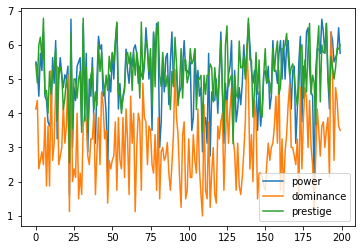

In [14]:
df_study1t[["power", "dominance", "prestige"]].plot(kind='line')

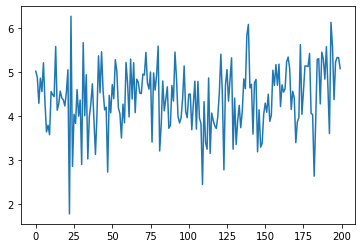

In [15]:
df_study1t[["power", "dominance", "prestige"]].mean(axis=1).plot(kind='line')

### Load and preprocess data

In [16]:
# load data
df_study1 = load_study1()
df_study2 = load_study2()

In [17]:
%%script false --no-raise-error
%%time
# tokenize, postag, ...
df_study1["text_spacy_doc"] = nlpize(df_study1["text"], nlp)
df_study2["text_spacy_doc"] = nlpize(df_study2["text"], nlp)

# remove punctuation
df_study1["text_spacy_doc_filtered"] = clean(df_study1["text_spacy_doc"], stopwords=False, alpha=False, punctuation=True)
df_study2["text_spacy_doc_filtered"] = clean(df_study2["text_spacy_doc"], stopwords=False, alpha=False, punctuation=True)

# take raw text `tok.text` instead of lemma `tok.lemma_`
df_study1["tokens"] = df_study1["text_spacy_doc_filtered"].map(lambda doc: list(map(lambda tok: tok.text, doc)))
df_study2["tokens"] = df_study2["text_spacy_doc_filtered"].map(lambda doc: list(map(lambda tok: tok.text, doc)))
# convert to plain string
df_study1["tokens"] = df_study1["tokens"].map(lambda doc: list(map(str, doc)))
df_study2["tokens"] = df_study2["tokens"].map(lambda doc: list(map(str, doc)))

# concat both studies
#docs = pd.concat([df_study1["tokens"], df_study2["tokens"]], ignore_index=True)
#docs_raw = docs.map(lambda doc: " ".join(doc))

### SetFit

#### Prepare datasets

In [18]:
import datasets

In [19]:
num_classes = 7
num_samples_per_class = 10

#category = "power"
#category = "dominance"
category = "prestige"

In [20]:
# convert to ints (labels)
for col in ("power", "dominance", "prestige") + ("power_f", "dominance_f", "prestige_f"):
    df_study1[col] = df_study1[col].map(round)

    # remove "-9" values
    df_study1 = df_study1[df_study1[col].isin({1, 2, 3, 4, 5, 6, 7})]


for col in ("power", "dominance", "prestige") + ("power_f", "dominance_f", "prestige_f"):
    df_study2[col] = df_study2[col].map(round)

    # remove "-9" values
    df_study2 = df_study2[df_study2[col].isin({1, 2, 3, 4, 5, 6, 7})]


#df_study1.describe()
#df_study1.head()

In [21]:
np.random.seed(42)

num_train_samples = num_samples_per_class * num_classes

idx = df_study1.index.values
np.random.shuffle(idx)
df_study1_train = df_study1.iloc[idx[:num_train_samples]]
df_study1_test = df_study1.iloc[idx[num_train_samples:]]

X_tr = df_study1_train["text"]
y_tr = df_study1_train["power"]

X_ts = df_study1_test["text"]
y_ts = df_study1_test["power"]

In [22]:
ds_tr = datasets.Dataset.from_dict({"text": X_tr, "label": y_tr})
ds_ts = datasets.Dataset.from_dict({"text": X_ts, "label": y_ts})

In [23]:
ds_s2 = datasets.Dataset.from_dict({"text": df_study2["text"], "label": df_study2["power"]})

#### SetFit Model + train

Sentence Transformers
- https://huggingface.co/T-Systems-onsite/cross-en-de-roberta-sentence-transformer

In [24]:
from sentence_transformers.losses import CosineSimilarityLoss
from transformers import AutoTokenizer, AutoModel

from setfit import SetFitModel, SetFitTrainer

import evaluate

In [25]:
#tokenizer = AutoTokenizer.from_pretrained("T-Systems-onsite/german-roberta-sentence-transformer-v2")
#model = AutoModel.from_pretrained("T-Systems-onsite/german-roberta-sentence-transformer-v2")

In [26]:
#model = SetFitModel.from_pretrained("T-Systems-onsite/cross-en-de-roberta-sentence-transformer")
model = SetFitModel.from_pretrained("T-Systems-onsite/german-roberta-sentence-transformer-v2")
#model = SetFitModel.from_pretrained("distilbert-base-german-cased")
#model = SetFitModel.from_pretrained("german-nlp-group/electra-base-german-uncased")
# sentence-transformers/multi-qa-MiniLM-L6-dot-v1 / nreimers/MiniLM-L6-H384-uncased

Downloading:   0%|          | 0.00/541 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/541 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/188 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [27]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=ds_tr,
    eval_dataset=ds_ts,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=3, # The number of epochs to use for constrastive learning
    #column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [28]:
trainer.train()

***** Running training *****
  Num examples = 2800
  Num epochs = 3
  Total optimization steps = 175
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/175 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
metrics = trainer.evaluate()
metrics

In [ ]:
# note: code extracted from `trainer.evaluate()` of `SetFitTrainer`
# eval on other dataset
x_test = df_study2["text"]
y_test = df_study2[category]

metric_fn = evaluate.load(trainer.metric, config_name=None)
y_pred = trainer.model.predict(x_test)
metric_fn.compute(predictions=y_pred, references=y_test)

In [ ]:
# eval on training data should be really high after training
x_test = df_study1["text"]
y_test = df_study1[category]

metric_fn = evaluate.load(trainer.metric, config_name=None)
y_pred = trainer.model.predict(x_test)
metric_fn.compute(predictions=y_pred, references=y_test)

## Other stuff